In [6]:

import torch
from segment_anything import sam_model_registry
import matplotlib.pyplot as plt
from models.sam_decoder import SAM_Decoder
from torchvision import transforms
from PIL import Image

encoder_path = '/root/ai/weights/sam_vit_b_01ec64.pth'
decoder_model_path = '/root/ai/weights/sam_enc_custom_decoder.pt'
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
print(device)

sam = sam_model_registry["vit_b"](checkpoint=encoder_path)
sam = sam.to(device)

cuda:0


In [7]:
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    pass
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)
# 여기서부터 Encoder no 추가하기

Last layer No:  176


In [8]:
sam_decoder = SAM_Decoder(sam_encoder = sam.image_encoder, sam_preprocess = sam.preprocess)
sam_decoder = sam_decoder.to(device)
# 디코더 가중치 로드
sam_decoder.load_state_dict(torch.load(decoder_model_path, map_location=device))
sam_decoder.eval()
print("SAM model + Custom Decoder set to EVAL mode")

Last layer No:  176
SAM model + Custom Decoder set to EVAL mode


Np arr shape:  (1024, 1024, 1) (1024, 1024)


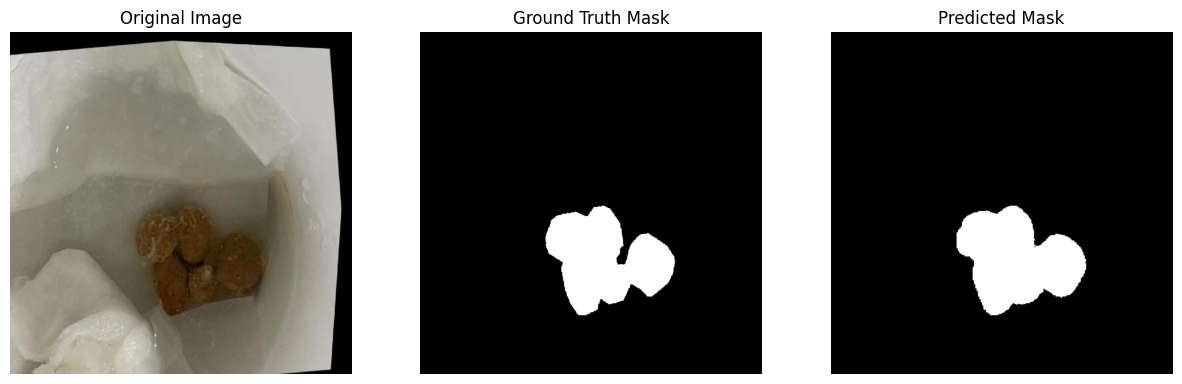

In [11]:
# 이미지 전처리
import numpy as np
import torchvision
# filename = 'Type4_iter275_jpg.rf.e2c3ef53d487afeef8bd9c69d0927e8a'
# filename = 'Type4_iter275_jpg.rf.e2c3ef53d487afeef8bd9c69d0927e8a'
filename = '33_jpeg_jpg.rf.afdfbc41a987670e2159597db4fc3f25'
input_img = f'/root/ai/dataset/mask_1513_split/img/{filename}.jpg'
mask_img = f'/root/ai/dataset/mask_1513_split/mask/{filename}_mask.png'

resize = transforms.Resize(
        (1024, 1024),
        interpolation=transforms.InterpolationMode.NEAREST
)

image = torchvision.io.read_image(input_img)
image = resize(image)

mask = torchvision.io.read_image(mask_img)
mask = resize(mask)

with torch.no_grad():
    # 모델에 입력하여 예측 수행
    pred_masks = sam_decoder(image.to(device).unsqueeze(0))

np_pred = ((pred_masks > 0.5) * 1).to("cpu").numpy()[0].transpose(1, 2, 0)

# gt_0_np는 이제 (1024, 1024) 크기로 축소됨
np_mask = mask.squeeze().to("cpu").numpy()
print("Np arr shape: ", np_pred.shape, np_mask.shape)

# 원본 이미지 변환
input_tensor_np = image.squeeze().cpu().numpy()
input_tensor_np = np.transpose(input_tensor_np, [1, 2, 0])

# 플롯 그리기
plt.figure(figsize=(15, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(input_tensor_np)
plt.title("Original Image")
plt.axis('off')

# GT 마스크
plt.subplot(1, 3, 2)
plt.imshow(np_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# 예측된 마스크
plt.subplot(1, 3, 3)
plt.imshow(np_pred, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

# 플롯 표시
plt.show()